In [1]:
import json
import os
import pickle
import psycopg2
import pandas as pd
import sqlalchemy
import sys
sys.path.append("..")

from connect_db import db_connection


import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import matplotlib.cm as cm
import seaborn as sns
get_ipython().magic(u'matplotlib inline')
%matplotlib inline

username='ywang99587'

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



from scipy.spatial import distance
import scipy.spatial.distance
from scipy.spatial.distance import cdist, pdist
import pylab as pl

In [2]:
#df_feature_all = pd.read_csv('/mnt/data/shared/Germany_Aug_features_with_locs.csv')
df_feature_all = pd.read_csv('/mnt/data/shared/ger3.csv')

In [4]:
df_feature_all.shape

(87134, 36)

In [5]:
#df_feature_all['num_loc_per_hr_tusc'] = df_feature_all['num_loc_in_tusc']/df_feature_all['hrs_in_tusc']

In [6]:
#df_feature_all2 = df_feature_all[(df_feature_all['num_loc_per_hr_tusc']>0.04) & (df_feature_all['num_loc_per_hr_tusc']<100)]

In [ ]:
df_feature_all.columns

In [ ]:
feature_hrs = ['hrs_in_tusc', 'hrs_outside_tuscany']
feature_locs = []

In [7]:
## standardize all continuous features
df_feature_cont = df_feature_all[['hrs_in_italy', 'hr_arvl_italy', 'day_of_wk_arvl_italy', 'mon_arvl_italy', 'day_arvl_italy',
       'num_unique_loc_in_italy', 'num_loc_in_italy','num_unique_loc_in_tusc', 'num_loc_in_tusc', 'hrs_in_tusc',
       'hr_arvl_tusc', 'day_of_wk_arvl_tusc', 'mon_arvl_tusc', 'day_arvl_tusc',
       'hrs_outside_tuscany', 'locs_outside_tuscany', 'unique_locs_outside_tuscany',
        'start_lat', 'start_lon','start_lat_tusc', 'start_lon_tusc',
       'end_lat', 'end_lon',  'avg_lat',
       'avg_lon', 'top_lat', 'top_lon' ]]#,
       #'forest', 'water', 'river', 'park', 'arezzo', 'florence', 'livorno',
       #'lucca', 'pisa', 'pistoia', 'siena', 'coast', 'num_attrs', 'towns',
       #'subrub']]
#df_feature_mcc = df_feature.join(mcc_fac)
scaler = StandardScaler()
scaled_feature_all = pd.DataFrame(scaler.fit_transform(df_feature_cont), columns = df_feature_cont.columns)
scaled_feature_all.head()

,hrs_in_italy,hr_arvl_italy,day_of_wk_arvl_italy,mon_arvl_italy,day_arvl_italy,num_unique_loc_in_italy,num_loc_in_italy,num_unique_loc_in_tusc,num_loc_in_tusc,hrs_in_tusc,...,start_lat,start_lon,start_lat_tusc,start_lon_tusc,end_lat,end_lon,avg_lat,avg_lon,top_lat,top_lon
0,0.838130,0.417979,-0.987607,0.532582,1.312849,-0.179328,1.854557,-0.216171,2.260194,0.825225,...,1.007176,0.377599,0.767380,0.533489,0.479101,0.451755,0.656106,0.531862,0.563534,0.455617
1,-0.312535,0.417979,0.080268,0.743761,-0.247719,0.365649,1.168468,0.514273,-0.107750,-0.268129,...,-0.263418,-0.600797,0.073386,-1.006840,-0.203652,-0.503298,0.877638,-1.375823,0.822416,-1.273510
2,0.473753,0.583545,1.682080,0.532582,1.104774,3.562300,1.756760,5.470854,1.782210,0.418845,...,2.256842,0.604880,0.627761,0.522471,1.209608,0.231951,0.086175,-0.213460,-0.605081,-0.708897
3,0.301153,-0.409854,-0.453670,0.743761,0.376508,2.439811,2.308941,2.444731,2.360919,0.225332,...,2.237185,0.572141,0.767380,0.533489,1.503230,0.934790,-0.020215,0.556123,-0.279814,0.494286
4,0.176498,-0.244287,-0.987607,0.532582,1.312849,1.772826,1.037569,0.079485,-0.303705,0.176953,...,2.237185,0.572141,0.775954,0.785397,-0.550389,0.350891,-2.160138,3.814171,-2.703937,4.088723


In [8]:
## relevant features
scaled_feature = scaled_feature_all[['unique_locs_outside_tuscany', 'locs_outside_tuscany','num_unique_loc_in_tusc', 
                                     'num_loc_in_tusc', 'hrs_in_tusc','hrs_outside_tuscany',
                                    'start_lat', 'start_lon', 'start_lat_tusc', 'start_lon_tusc',
       'end_lat', 'end_lon',  'avg_lat',
       'avg_lon', 'top_lat', 'top_lon']]#,
       # 'forest', 'water', 'river', 'park', 'arezzo', 'florence', 'livorno',
       #'lucca', 'pisa', 'pistoia', 'siena', 'coast', 'num_attrs', 'towns',
       # 'subrub']]
scaled_feature.corr()

,unique_locs_outside_tuscany,locs_outside_tuscany,num_unique_loc_in_tusc,num_loc_in_tusc,hrs_in_tusc,hrs_outside_tuscany,start_lat,start_lon,start_lat_tusc,start_lon_tusc,end_lat,end_lon,avg_lat,avg_lon,top_lat,top_lon
unique_locs_outside_tuscany,1.000000,0.857629,0.538336,0.278977,0.306258,0.508473,0.455850,0.006560,0.248290,0.186713,0.431765,0.006292,-0.318095,0.460674,-0.360845,0.448807
locs_outside_tuscany,0.857629,1.000000,0.484702,0.284854,0.230659,0.474137,0.325302,0.027274,0.186666,0.152350,0.304114,0.025156,-0.205310,0.337276,-0.246096,0.330600
num_unique_loc_in_tusc,0.538336,0.484702,1.000000,0.718701,0.258335,0.346846,0.282902,-0.002297,0.192276,0.099956,0.279014,-0.001247,0.030413,0.115223,-0.023675,0.116175
num_loc_in_tusc,0.278977,0.284854,0.718701,1.000000,0.225543,0.181022,0.167280,-0.004415,0.131082,0.051446,0.158322,0.004652,0.089154,0.005053,0.059581,0.006848
hrs_in_tusc,0.306258,0.230659,0.258335,0.225543,1.000000,0.092491,0.279628,-0.009610,0.212707,0.126066,0.235155,0.006406,-0.197712,0.283896,-0.180034,0.264139
hrs_outside_tuscany,0.508473,0.474137,0.346846,0.181022,0.092491,1.000000,0.245178,0.119643,0.052441,0.175735,0.220885,0.127242,-0.135010,0.245396,-0.182702,0.235927
start_lat,0.455850,0.325302,0.282902,0.167280,0.279628,0.245178,1.000000,-0.185236,0.707560,0.011227,0.461564,0.059263,0.046152,0.248116,-0.072294,0.268668
start_lon,0.006560,0.027274,-0.002297,-0.004415,-0.009610,0.119643,-0.185236,1.000000,-0.190217,0.615751,0.014714,0.317465,-0.037284,0.342794,-0.016396,0.260447
start_lat_tusc,0.248290,0.186666,0.192276,0.131082,0.212707,0.052441,0.707560,-0.190217,1.000000,-0.129195,0.321500,0.067702,0.229294,0.153476,0.110584,0.181734
start_lon_tusc,0.186713,0.152350,0.099956,0.051446,0.126066,0.175735,0.011227,0.615751,-0.129195,1.000000,0.164314,0.265388,-0.094944,0.552156,-0.090624,0.473170


In [9]:
## scaled features and lon lat
df_scaled_loc = pd.concat([scaled_feature.reset_index(drop=True), df_feature_all[['std_lat', 'std_lon']]], axis=1)
df_scaled_loc.head()

,unique_locs_outside_tuscany,locs_outside_tuscany,num_unique_loc_in_tusc,num_loc_in_tusc,hrs_in_tusc,hrs_outside_tuscany,start_lat,start_lon,start_lat_tusc,start_lon_tusc,end_lat,end_lon,avg_lat,avg_lon,top_lat,top_lon,std_lat,std_lon
0,-0.117231,-0.006131,-0.216171,2.260194,0.825225,0.288451,1.007176,0.377599,0.767380,0.533489,0.479101,0.451755,0.656106,0.531862,0.563534,0.455617,0.159498,0.076676
1,0.187517,3.288409,0.514273,-0.107750,-0.268129,-0.664845,-0.263418,-0.600797,0.073386,-1.006840,-0.203652,-0.503298,0.877638,-1.375823,0.822416,-1.273510,0.123580,0.176967
2,1.504027,0.765350,5.470854,1.782210,0.418845,0.833192,2.256842,0.604880,0.627761,0.522471,1.209608,0.231951,0.086175,-0.213460,-0.605081,-0.708897,0.980120,0.410009
3,1.942864,0.966093,2.444731,2.360919,0.225332,1.105562,2.237185,0.572141,0.767380,0.533489,1.503230,0.934790,-0.020215,0.556123,-0.279814,0.494286,0.974046,0.150742
4,2.601119,3.367132,0.079485,-0.303705,0.176953,0.016081,2.237185,0.572141,0.775954,0.785397,-0.550389,0.350891,-2.160138,3.814171,-2.703937,4.088723,1.724480,1.596464


In [10]:
data=df_scaled_loc[df_scaled_loc['std_lat']>0]

In [12]:
data.columns

Index(['unique_locs_outside_tuscany', 'locs_outside_tuscany',
       'num_unique_loc_in_tusc', 'num_loc_in_tusc', 'hrs_in_tusc',
       'hrs_outside_tuscany', 'start_lat', 'start_lon', 'start_lat_tusc',
       'start_lon_tusc', 'end_lat', 'end_lon', 'avg_lat', 'avg_lon', 'top_lat',
       'top_lon', 'std_lat', 'std_lon'],
      dtype='object')

In [11]:
df_feature_data = df_feature_all[df_feature_all['std_lat']>0] ## for descriptives

In [12]:
df_feature_data.shape

(83774, 36)

In [13]:
data.shape

(83774, 18)

In [16]:
kmeans = KMeans(n_clusters=5, n_jobs=-1)
kmeans.fit(data)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [17]:
labels = kmeans.labels_

In [18]:
data.head()

,unique_locs_outside_tuscany,locs_outside_tuscany,num_unique_loc_in_tusc,num_loc_in_tusc,hrs_in_tusc,hrs_outside_tuscany,start_lat,start_lon,start_lat_tusc,start_lon_tusc,end_lat,end_lon,avg_lat,avg_lon,top_lat,top_lon,std_lat,std_lon
0,-0.117231,-0.006131,-0.216171,2.260194,0.825225,0.288451,1.007176,0.377599,0.767380,0.533489,0.479101,0.451755,0.656106,0.531862,0.563534,0.455617,0.159498,0.076676
1,0.187517,3.288409,0.514273,-0.107750,-0.268129,-0.664845,-0.263418,-0.600797,0.073386,-1.006840,-0.203652,-0.503298,0.877638,-1.375823,0.822416,-1.273510,0.123580,0.176967
2,1.504027,0.765350,5.470854,1.782210,0.418845,0.833192,2.256842,0.604880,0.627761,0.522471,1.209608,0.231951,0.086175,-0.213460,-0.605081,-0.708897,0.980120,0.410009
3,1.942864,0.966093,2.444731,2.360919,0.225332,1.105562,2.237185,0.572141,0.767380,0.533489,1.503230,0.934790,-0.020215,0.556123,-0.279814,0.494286,0.974046,0.150742
4,2.601119,3.367132,0.079485,-0.303705,0.176953,0.016081,2.237185,0.572141,0.775954,0.785397,-0.550389,0.350891,-2.160138,3.814171,-2.703937,4.088723,1.724480,1.596464


In [20]:
rdf = data[['num_loc_in_tusc','num_unique_loc_in_tusc', 
        'locs_outside_tuscany', 'unique_locs_outside_tuscany', 
        'start_lat', 'start_lon',
       'end_lat', 'end_lon', 'avg_lat',
       'avg_lon', 'top_lat', 'top_lon', 'std_lat', 'std_lon']]

In [17]:
rdf[rdf.columns]=rdf[rdf.columns].astype(float)

/home/ywang99587/.conda/envs/tptyw/lib/python3.6/site-packages/pandas/core/frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [18]:
rdf['col']=labels.astype(str)

/home/ywang99587/.conda/envs/tptyw/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [ ]:
sns.pairplot(rdf,hue='col')

KeyboardInterrupt: 

In [21]:
len(labels)

83774

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0e16d82470>]],
      dtype=object)

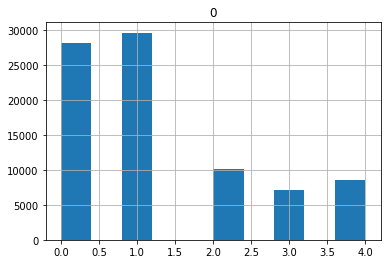

In [22]:
pd.DataFrame(labels).hist()

In [23]:
data['label']=labels

/home/ywang99587/.conda/envs/tptyw/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


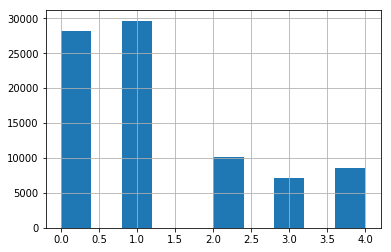

In [24]:
data.label.hist()

In [19]:
## desc by cluster? - use unscaled data

In [25]:
df_feature_data['label']=labels

/home/ywang99587/.conda/envs/tptyw/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [26]:
#df_feature_data.to_csv('/mnt/data/shared/customer_clustering_label.csv')

In [33]:
df_feature_data_redc = df_feature_data[['avg_lat', 'avg_lon', 'top_lat', 'top_lon', 'label']]
df_feature_data_redc.head()

,avg_lat,avg_lon,top_lat,top_lon,label
0,43.892021,11.553571,43.8627,11.5682,0
1,44.062777,9.913151,44.1076,9.8287,1
2,43.452721,10.912668,42.7572,10.3967,2
3,43.370716,11.574433,43.0649,11.6071,2
4,41.721275,14.376030,40.7717,15.2231,3


In [34]:
provinces = r"/mnt/data/shared/Boundaries regions and municipalities Italy 2016/CMProv2016_WGS84_g/CMprov2016_WGS84_g.shp"
territories =  r"/mnt/data/shared/Tus_28districts.shp"

In [47]:
gdf_pro = gpd.read_file(provinces)
gdf_ter = gpd.read_file(territories)

# Convert coordinates in WGS84 to Lat Lon format 
# see http://geopandas.org/projections.html
#gdf_reg['geometry'] = gdf_reg['geometry'].to_crs(epsg=4326)
gdf_pro['geometry'] = gdf_pro['geometry'].to_crs(epsg=4326)
#gdf_mun['geometry'] = gdf_mun['geometry'].to_crs(epsg=4326)

# important cities 
important_cities_tuscany = r"/mnt/data/shared/important_cities.csv"
df_impcit = pd.read_csv(important_cities_tuscany)

# 9 is for Tuscany only
#gdf_reg_tus = gdf_reg[gdf_reg["COD_REG"] == 9] 
gdf_pro_tus = gdf_pro[gdf_pro["COD_REG"] == 9]
gdf_ter_tus = gdf_ter # this one is already Tuscany only
#gdf_mun_tus = gdf_mun[gdf_mun["COD_REG"] == 9]

In [48]:
df_impcit.head()

,city,lat,long
0,Siena,43.3188,11.3308
1,Pisa,43.7228,10.4017
2,Florence,43.7696,11.2558
3,Lucca,43.8376,10.4951
4,Arezzo,43.4633,11.8796


In [49]:
from geopandas import GeoDataFrame
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df_impcit.long, df_impcit.lat)]
df_impcit = df_impcit.drop(['long', 'lat'], axis=1)
crs = {'init': 'epsg:4326'}
geo_df_impcit = GeoDataFrame(df_impcit, crs=crs, geometry=geometry)
geo_df_impcit.head()

,city,geometry
0,Siena,POINT (11.3308 43.3188)
1,Pisa,POINT (10.4017 43.7228)
2,Florence,POINT (11.2558 43.7696)
3,Lucca,POINT (10.4951 43.8376)
4,Arezzo,POINT (11.8796 43.4633)


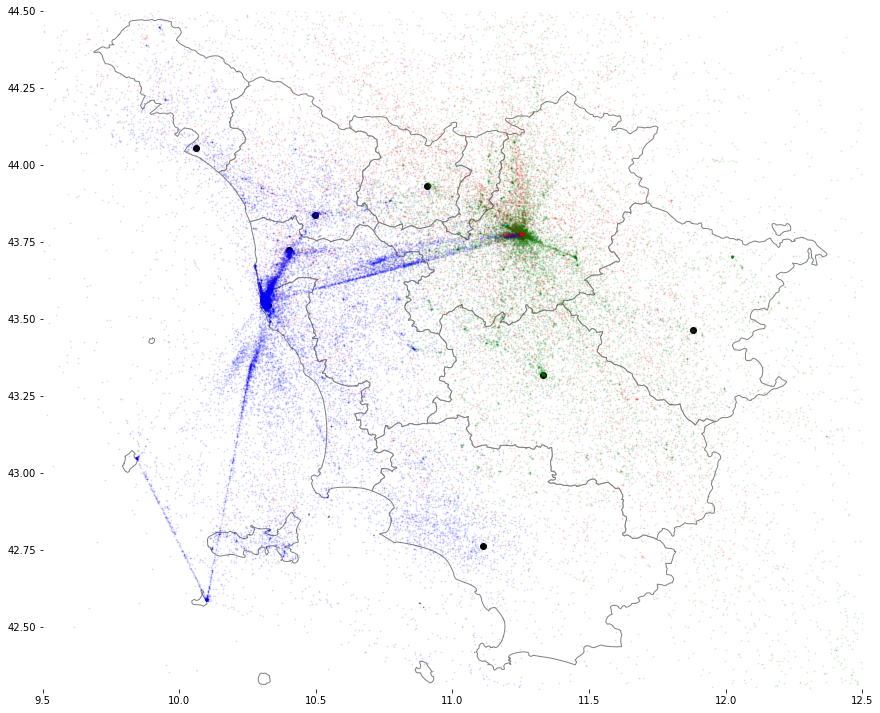

In [51]:
## plot avg

fig = plt.figure(figsize=(12, 10))
ax = plt.gca()


cluster = df_feature_data_redc[df_feature_data_redc['label'] == 0]
plt.plot(cluster['avg_lon'].iloc[:], cluster['avg_lat'].iloc[:], 'go', markersize=0.9, alpha=0.1)
  
#cluster = df_feature_data_redc[df_feature_data_redc['label'] == 1]
#plt.plot(cluster['avg_lon'].iloc[:], cluster['avg_lat'].iloc[:], 'bo', markersize=0.5, alpha=0.3)

#cluster = df_feature_data_redc[df_feature_data_redc['label'] == 2]
#plt.plot(cluster['top_lon'].iloc[:], cluster['top_lat'].iloc[:], 'go', markersize=0.5, alpha=0.3)

cluster = df_feature_data_redc[df_feature_data_redc['label'] == 1]
plt.plot(cluster['avg_lon'].iloc[:], cluster['avg_lat'].iloc[:], 'bo', markersize=0.9, alpha=0.1)

cluster = df_feature_data_redc[df_feature_data_redc['label'] == 2]
plt.plot(cluster['avg_lon'].iloc[:], cluster['avg_lat'].iloc[:], 'ro', markersize=0.9, alpha=0.1)
    
    
gdf_pro_tus.plot(ax=ax, color='white', edgecolor='gray', alpha=0.99)
#important_cities(df_impcit)
geo_df_impcit.plot(ax=ax, color='black');
plt.tight_layout();


plt.ylim([42.3, 44.5])
plt.xlim([9.5, 12.5])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False) 

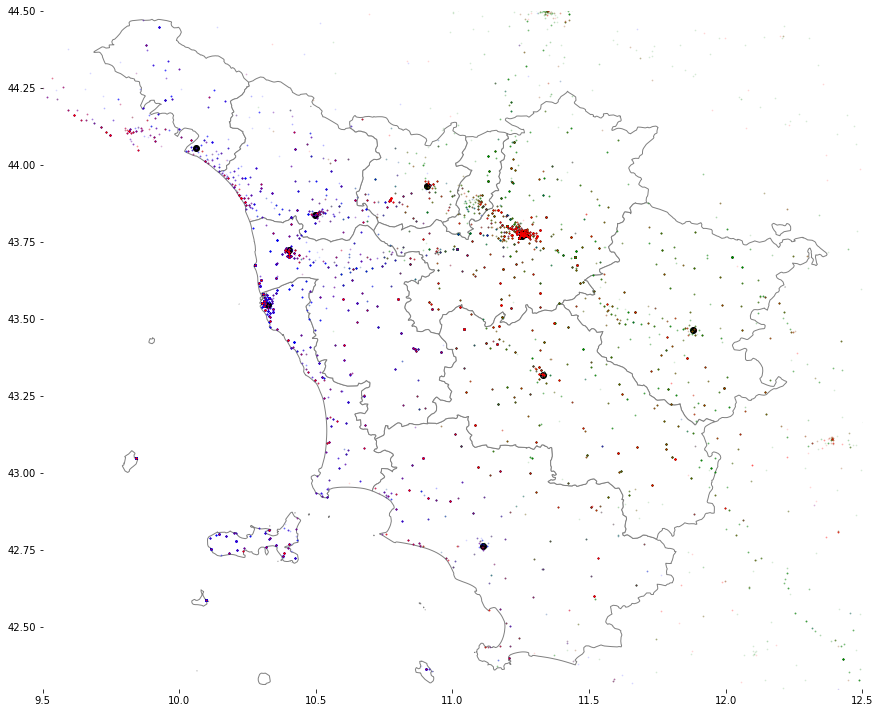

In [52]:

## plot avg

fig = plt.figure(figsize=(12, 10))
ax = plt.gca()


cluster = df_feature_data_redc[df_feature_data_redc['label'] == 0]
plt.plot(cluster['top_lon'].iloc[:], cluster['top_lat'].iloc[:], 'go', markersize=0.9, alpha=0.1)
  
#cluster = df_feature_data_redc[df_feature_data_redc['label'] == 1]
#plt.plot(cluster['top_lon'].iloc[:], cluster['top_lat'].iloc[:], 'bo', markersize=0.5, alpha=0.3)

#cluster = df_feature_data_redc[df_feature_data_redc['label'] == 2]
#plt.plot(cluster['top_lon'].iloc[:], cluster['top_lat'].iloc[:], 'go', markersize=0.5, alpha=0.3)

cluster = df_feature_data_redc[df_feature_data_redc['label'] == 1]
plt.plot(cluster['top_lon'].iloc[:], cluster['top_lat'].iloc[:], 'bo', markersize=0.9, alpha=0.1)

cluster = df_feature_data_redc[df_feature_data_redc['label'] == 2]
plt.plot(cluster['top_lon'].iloc[:], cluster['top_lat'].iloc[:], 'ro', markersize=0.9, alpha=0.1)
    
    
gdf_pro_tus.plot(ax=ax, color='white', edgecolor='gray', alpha=0.99)
#important_cities(df_impcit)
geo_df_impcit.plot(ax=ax, color='black');
plt.tight_layout();


plt.ylim([42.3, 44.5])
plt.xlim([9.5, 12.5])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False) 

In [27]:
clusters=[]
clen=0
for i in range(0,5):
    cluster=df_feature_data[df_feature_data['label']==i]
    clusters.append(cluster)
    clen+=len(cluster)
    print(clusters[i].shape)

(28128, 37)
(29659, 37)
(10189, 37)
(7167, 37)
(8631, 37)


In [103]:
70149/clen

0.33747221767869684

In [26]:
df_feature_data.columns

Index(['Unnamed: 0', 'mcc', 'hr_arvl_tusc', 'day_of_wk_arvl_tusc',
       'mon_arvl_tusc', 'day_arvl_tusc', 'loc_arvl_tusc', 'hr_arvl_italy',
       'day_of_wk_arvl_italy', 'mon_arvl_italy', 'day_arvl_italy',
       'loc_arvl_italy', 'locs_outside_tuscany', 'num_uniuqe_loc_in_italy',
       'num_loc_in_italy', 'num_uniuqe_loc_in_tusc', 'num_loc_in_tusc',
       'unique_locs_outside_tuscany', 'customer_nr', 'start_lat', 'start_lon',
       'end_lat', 'end_lon', 'hrs_in_italy', 'hrs_in_tusc', 'avg_lat',
       'avg_lon', 'top_lat', 'top_lon', 'std_lat', 'std_lon',
       'hrs_outside_tuscany', 'start_lat_tusc', 'start_lon_tusc', 'total_time',
       'forest', 'water', 'river', 'park', 'arezzo', 'florence', 'livorno',
       'lucca', 'pisa', 'pistoia', 'siena', 'coast', 'num_attrs', 'towns',
       'islands', 'subrub', 'label'],
      dtype='object')

In [30]:
cols = ['hrs_in_tusc','hrs_outside_tuscany', #'hrs_in_italy', 
        'num_loc_in_tusc','num_unique_loc_in_tusc', 
        'locs_outside_tuscany', 'unique_locs_outside_tuscany', 
       #'num_loc_in_italy', 'num_uniuqe_loc_in_italy',
        'start_lat', 'start_lon', 'start_lat_tusc', 'start_lon_tusc',
       'end_lat', 'end_lon', 'avg_lat',
       'avg_lon', 'top_lat', 'top_lon', 'std_lat', 'std_lon']#,
       #'forest', 'water', 'river', 'park', 'arezzo', 'florence', 'livorno',
       #'lucca', 'pisa', 'pistoia', 'siena', 'coast', 'num_attrs', 'towns',
       #'subrub']

In [31]:
cluster_stats = []
for col in cols:
    ls_col = []
    for i in range(0,5):
        statsdf = clusters[i].describe()
        statscol = statsdf[col]
        ls_col.append(statscol)
    df_col = pd.concat(ls_col, axis=1).round(2)
    cluster_stats.append(df_col)
    print(df_col)
df_cluster = pd.concat(cluster_stats, axis=1)

       hrs_in_tusc  hrs_in_tusc  hrs_in_tusc  hrs_in_tusc  hrs_in_tusc
count     28128.00     29659.00     10189.00      7167.00      8631.00
mean         76.76        45.26       133.71       177.03        43.67
std          95.35        81.93       116.02       132.70        72.08
min           1.00         1.00         2.00         1.00         1.00
25%          22.00        10.00        62.00        86.00        10.00
50%          49.00        14.00        96.00       134.00        22.00
75%          95.00        38.00       165.00       236.50        44.00
max         720.00       719.00       720.00       720.00       704.00
       hrs_outside_tuscany  hrs_outside_tuscany  hrs_outside_tuscany  \
count             28128.00             29659.00             10189.00   
mean                  2.42                 1.95                12.81   
std                   4.68                 5.27                 8.20   
min                   0.00                 0.00                 0.00   
2

       start_lon_tusc  start_lon_tusc  start_lon_tusc  start_lon_tusc  \
count        28128.00        29659.00        10189.00         7167.00   
mean            11.26           10.31           10.97           11.18   
std              0.26            0.26            0.61            0.38   
min              9.84            8.16            8.16            8.16   
25%             11.20           10.29           10.42           11.21   
50%             11.25           10.30           11.23           11.23   
75%             11.26           10.35           11.23           11.23   
max             13.75           11.95           13.91           13.91   

       start_lon_tusc  
count         8631.00  
mean            11.48  
std              0.72  
min              9.17  
25%             10.92  
50%             11.38  
75%             11.94  
max             17.00  
        end_lat   end_lat   end_lat  end_lat  end_lat
count  28128.00  29659.00  10189.00  7167.00  8631.00
mean      43.75   

In [29]:
top_start_locs = []
top_start_ratio = []
for cluster in clusters:
    cluster['start_lat2'] = cluster.start_lat.round(2)
    cluster['start_lon2'] = cluster.start_lon.round(2)
    cluster_loc = pd.DataFrame(cluster.groupby(['start_lat2','start_lon2']).count())
    cluster_loc = cluster_loc.sort_values('mcc',ascending=False)
    top_start_locs.append(pd.Series(cluster_loc.iloc[0].name))
    top_start_ratio.append(cluster_loc.iloc[0,1]/len(cluster))
    

/home/ywang99587/.conda/envs/tptyw/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ywang99587/.conda/envs/tptyw/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [30]:
df_top_start = pd.concat(top_start_locs, axis=1)

In [31]:
df_top_start

,0,1,2,3,4
0,43.55,46.96,46.96,46.96,43.77
1,10.30,11.47,11.47,11.47,11.25


In [32]:
top_start_ratio

[0.030278407389984177,
 0.18202982445101618,
 0.1767347022841019,
 0.13849241748438895,
 0.03883381534295124]

In [33]:
top_end_locs = []
top_end_ratio = []
for cluster in clusters:
    cluster['end_lat2'] = cluster.end_lat.round(2)
    cluster['end_lon2'] = cluster.end_lon.round(2)
    cluster_loc = pd.DataFrame(cluster.groupby(['end_lat2','end_lon2']).count())
    cluster_loc = cluster_loc.sort_values('mcc',ascending=False)
    top_end_locs.append(pd.Series(cluster_loc.iloc[0].name))
    top_end_ratio.append(cluster_loc.iloc[0,1]/len(cluster))
    

/home/ywang99587/.conda/envs/tptyw/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ywang99587/.conda/envs/tptyw/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [34]:
df_top_end = pd.concat(top_end_locs, axis=1)

In [35]:
df_top_end

,0,1,2,3,4
0,43.55,46.99,46.99,46.99,43.77
1,10.30,11.50,11.50,11.50,11.25


In [36]:
top_end_ratio

[0.02812584641263596,
 0.11011136978544013,
 0.08883076225979857,
 0.07329765090692834,
 0.028987445460472425]

In [187]:
cluster=df_feature_data[df_feature_data['label']==0]

In [188]:
cluster['start_lat2'] = cluster.start_lat.round(2)
cluster['start_lon2'] = cluster.start_lon.round(2)

/home/ywang99587/.conda/envs/tptyw/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/ywang99587/.conda/envs/tptyw/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [102]:
cluster_loc = pd.DataFrame(cluster.groupby(['start_lat2','start_lon2']).count())

In [103]:
cluster_loc = cluster_loc.sort_values('mcc',ascending=False)

In [104]:
len(cluster_loc)

4010

In [110]:
#cluster_loc

In [90]:
aa=cluster_loc.iloc[0].name

In [91]:
type(aa)

tuple

In [92]:
pd.Series(cluster_loc.iloc[0].name)

0    46.96
1    11.47
dtype: float64

In [144]:
cluster_stats[9]

,end_lon,end_lon,end_lon,end_lon,end_lon
count,17868.00,16814.00,120692.00,49383.00,13586.00
mean,12.27,10.77,10.81,10.44,10.98
std,2.03,1.24,0.61,1.16,1.81
min,7.26,6.70,6.82,6.70,6.98
25%,11.02,10.23,10.40,9.06,9.84
50%,11.93,10.99,10.79,10.75,11.07
75%,12.64,11.50,11.25,11.43,11.50
max,18.49,18.46,15.51,14.27,18.49


In [134]:
df_cluster

,hrs_in_tusc,hrs_in_tusc,hrs_in_tusc,hrs_in_tusc,hrs_in_tusc,hrs_outside_tuscany,hrs_outside_tuscany,hrs_outside_tuscany,hrs_outside_tuscany,hrs_outside_tuscany,...,std_lat,std_lat,std_lat,std_lat,std_lat,std_lon,std_lon,std_lon,std_lon,std_lon
count,17868.00,16814.00,120692.00,49383.00,13586.00,17868.00,16814.00,120692.00,49383.00,13586.00,...,17868.00,16814.00,120692.00,49383.00,13586.00,17868.00,16814.00,120692.00,49383.00,13586.00
mean,132.01,337.20,181.88,266.43,375.13,13.45,9.67,0.95,10.83,8.97,...,0.84,0.63,0.25,0.87,1.72,0.82,0.42,0.25,0.53,1.68
std,139.59,140.55,143.77,142.47,169.61,7.32,6.68,2.39,6.07,6.25,...,0.54,0.31,0.31,0.45,0.69,0.60,0.28,0.31,0.37,0.62
min,1.00,28.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
25%,25.00,238.00,63.00,162.00,263.00,8.00,5.00,0.00,6.00,5.00,...,0.44,0.42,0.05,0.57,1.38,0.43,0.24,0.06,0.29,1.27
50%,79.00,329.00,160.00,262.00,383.00,13.00,8.00,0.00,9.00,8.00,...,0.80,0.59,0.13,0.78,1.77,0.67,0.35,0.16,0.44,1.74
75%,190.00,415.00,278.00,341.00,499.00,18.00,14.00,0.00,14.00,12.00,...,1.13,0.78,0.33,1.07,2.18,1.04,0.53,0.34,0.66,2.09
max,720.00,720.00,720.00,720.00,720.00,46.00,39.00,25.00,46.00,43.00,...,3.87,3.26,3.47,3.65,3.74,5.51,2.92,4.88,3.99,5.44


In [31]:
df_cluster.to_csv('/mnt/data/shared/cluster_stats.csv')

In [109]:
ls_col = []
for i in range(0,5):
        statsdf = clusters[i].describe()
        statscol = statsdf['end_lon']
        ls_col.append(statscol)
df_col = pd.concat(ls_col, axis=1).round(2)

In [148]:
df_col

,end_lon,end_lon,end_lon,end_lon,end_lon
count,17447.00,13372.00,48564.00,16590.00,116245.00
mean,10.86,10.84,10.84,10.85,10.86
std,1.22,1.25,1.21,1.22,1.15
min,6.70,6.71,6.71,6.70,6.70
25%,10.32,10.31,10.31,10.31,10.33
50%,10.88,10.87,10.89,10.88,10.86
75%,11.36,11.38,11.38,11.38,11.33
max,18.49,18.41,18.49,18.45,18.49


In [82]:
clusters[i]['mcc'].mean()

262.0

In [43]:
df_feature_all[['avg_lat', 'avg_lon', 'std_lat','std_lon']].describe()

,avg_lat,avg_lon,std_lat,std_lon
count,213690.000000,213690.000000,213690.000000,213690.000000
mean,43.228931,11.143180,0.555454,0.457351
std,0.995080,1.170873,0.573122,0.521002
min,36.817522,6.884848,0.000000,0.000000
25%,42.963389,10.469542,0.099661,0.117832
50%,43.422874,10.911800,0.389074,0.295438
75%,43.763959,11.400464,0.815435,0.573665
max,46.951622,18.481355,3.874449,5.435459


In [75]:
means=df_feature_all[['avg_lat', 'avg_lon', 'std_lat','std_lon']].mean()

In [77]:
len(means)

4

In [74]:
df_feature_all[['avg_lat', 'avg_lon', 'std_lat','std_lon']].mean()

avg_lat    43.228931
avg_lon    11.143180
std_lat     0.555454
std_lon     0.457351
dtype: float64

In [72]:
places=[12,13,31,32]

In [76]:
stds=df_feature_all[['avg_lat', 'avg_lon', 'std_lat','std_lon']].std()

In [44]:
centers = kmeans.cluster_centers_

In [71]:
centers.shape

(5, 33)

In [84]:
means, stds

(avg_lat    43.228931
 avg_lon    11.143180
 std_lat     0.555454
 std_lon     0.457351
 dtype: float64, avg_lat    0.995080
 avg_lon    1.170873
 std_lat    0.573122
 std_lon    0.521002
 dtype: float64)

In [88]:
avg_lat_centers = []
for i in range(0,5):
    for j in range(0,len(places)):
        print(centers[i,places[j]])
        avg_lat_centers.append(centers[i,places[j]]*stds[j]+means[j])


0.16911136865737753
-0.5319162965589669
0.2775069609089853
0.26018510846259224
0.4196239283601456
-0.2111430837711443
0.5464985618718593
0.3750503239321606
0.1503418072463577
-0.2415560269555529
0.8940502923070595
0.5618018183691129
-2.6503427625126594
3.022359308301012
1.7241364614927135
1.6682291097234612
0.14251283260630668
0.22574321179806095
0.40026529385407483
0.3979192548318065


In [89]:
avg_lat_centers

[43.39721061600345,
 10.520373069377042,
 0.714498873619422,
 0.592907849422025,
 43.64649057231074,
 10.895957856339464,
 0.8686638541465426,
 0.6527528130497124,
 43.37853340694855,
 10.860348153498187,
 1.067853366246234,
 0.750050644654413,
 40.591629117565255,
 14.681979439981527,
 1.543593938257629,
 1.3265010586208943,
 43.37074295341393,
 11.407496350536293,
 0.784854364052127,
 0.6646675631531151]

In [91]:
lats=avg_lat_centers[::4]

In [92]:
lons=avg_lat_centers[1::4]

In [94]:
lats_std=avg_lat_centers[2::4]

In [95]:
lons_std=avg_lat_centers[3::4]

In [96]:
a=pd.DataFrame()

In [97]:
a['lats']=lats
a['lons']=lons
a['lats_std']=lats_std
a['lons_std']=lons_std

In [98]:
a.head()

,lats,lons,lats_std,lons_std
0,43.397211,10.520373,0.714499,0.592908
1,43.646491,10.895958,0.868664,0.652753
2,43.378533,10.860348,1.067853,0.750051
3,40.591629,14.681979,1.543594,1.326501
4,43.370743,11.407496,0.784854,0.664668


In [99]:
a.to_csv("/mnt/data/shared/coordinates_for_bruno_in_florence_after_croatia_won.csv")

In [60]:
avg_lat_centers

[43.39716581181409,
 43.64642580871835,
 43.37849009821013,
 40.59180895129991,
 43.37070026844328]

In [61]:
avg_lon_centers = []
for i in range(0,5):
    avg_lon_centers.append(centers[i,13]*1.1709+11.1432)

In [62]:
avg_lon_centers

[10.520379208359106,
 10.895972563212368,
 10.860362048037743,
 14.682080514089655,
 11.40752272669435]

In [64]:
avg_lat_centers = []
for i in range(0,5):
    avg_lat_centers.append(centers[i,31]*+43.2289)

0.26018510846259224

In [ ]:
avg_lon_centers = []
for i in range(0,5):
    avg_lon_centers.append(centers[i,13]*1.1709+11.1432)

In [52]:
kmeans.cluster_centers_

array([[-5.50689512e-01, -4.21049264e-01, -4.71640271e-01,
        -3.19846630e-01, -2.05550558e-01, -5.91471627e-01,
        -4.46875586e-01, -3.46284981e-01, -3.38553665e-01,
        -5.97560340e-01, -3.82448535e-01, -2.37053015e-01,
         1.69111369e-01, -5.31916297e-01,  1.85766604e-01,
        -4.99404810e-01,  6.06564770e-02, -2.63373102e-02,
        -1.47609827e-02, -8.21093366e-03, -7.57670517e-02,
        -1.85661101e-01,  9.18043113e-02,  1.17105898e-01,
         7.02120086e-02,  2.91661632e-02, -1.09432845e-01,
         1.28463804e-01, -2.43197224e-01, -1.45037676e-01,
         1.26747283e-03,  2.77506961e-01,  2.60185108e-01],
       [ 8.02995683e-01,  5.39645304e-01,  2.34716005e+00,
         2.43039173e+00,  7.02305820e-01,  6.01231880e-01,
         8.90501215e-01, -2.32197613e-01,  7.05127664e-01,
        -1.24704467e-01,  6.25088150e-01, -5.09090375e-02,
         4.19623928e-01, -2.11143084e-01,  3.99196620e-01,
        -2.08630703e-01,  1.58558390e-01,  2.11145368e-

In [ ]:
## recluster biggest one  -- check labels first



In [111]:
data2 = data[data['label']==0]

In [112]:
len(data2)

120699

In [113]:
data2.head()

,unique_locs_outside_tuscany,locs_outside_tuscany,num_uniuqe_loc_in_tusc,num_loc_in_tusc,hrs_in_tusc,hrs_outside_tuscany,start_lat,start_lon,end_lat,end_lon,avg_lat,avg_lon,top_lat,top_lon,std_lat,std_lon,label
18,-0.540950,-0.411654,-0.604410,-0.414005,2.273649,-0.765600,-0.352586,0.348938,-0.247437,0.353126,0.450288,0.155631,0.499923,0.084322,0.806282,0.537648,0
19,-0.577958,-0.436869,0.273213,-0.033163,2.973688,-0.765600,-0.331317,0.299638,-0.317227,0.523109,0.284454,0.281040,0.527486,0.038918,0.248336,0.281057,0
25,-0.207885,-0.310798,-0.108977,-0.186272,1.629862,-0.618588,0.433441,-0.749110,-0.125524,0.145724,0.870415,-0.849079,2.259274,-1.587845,0.702639,0.616580,0
31,-0.331242,-0.336012,-0.406237,-0.379266,2.523663,-0.618588,0.010236,0.355829,-0.286274,-0.387386,0.953577,-2.258853,0.888880,-2.131333,0.291921,0.664444,0
36,-0.331242,-0.344417,-0.208064,1.378271,1.998633,-0.765600,-0.593919,0.021886,-0.448703,-0.449347,0.796281,-0.012520,0.067189,-0.075763,0.360924,0.063792,0


In [114]:
df_feature_data2 = df_feature_data[df_feature_data['label']==0]
df_feature_data2.head()

,Unnamed: 0,mcc,hr_arvl_tusc,day_of_wk_arvl_tusc,mon_arvl_tusc,day_arvl_tusc,loc_arvl_tusc,hr_arvl_italy,day_of_wk_arvl_italy,mon_arvl_italy,...,hrs_in_italy,hrs_in_tusc,avg_lat,avg_lon,top_lat,top_lon,std_lat,std_lon,hrs_outside_tuscany,label
18,18,262,12,1,7,10,3032941,12,1,7,...,581.0,581.0,43.681481,11.318461,43.7696,11.2597,0.806282,0.537648,0.0,0
19,19,262,13,6,7,8,59932031,13,6,7,...,693.0,693.0,43.517383,11.465295,43.8019,11.1996,0.248336,0.281057,0.0,0
25,25,262,13,6,7,15,57458012,12,6,7,...,479.0,478.0,44.097212,10.142101,45.8313,9.0463,0.702639,0.616580,1.0,0
31,31,262,13,4,7,6,3631303,12,4,7,...,622.0,621.0,44.179504,8.491475,44.2254,8.3269,0.291921,0.664444,1.0,0
36,36,262,11,2,7,11,3651814,11,2,7,...,537.0,537.0,44.023854,11.121582,43.2625,11.0478,0.360924,0.063792,0.0,0


In [115]:
kmeans2 = KMeans(n_clusters=2, n_jobs=-1)
kmeans2.fit(data2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [116]:
labels2 = kmeans2.labels_

In [117]:
type(labels2)

numpy.ndarray

In [94]:
np.unique(labels2)

array([0, 1], dtype=int32)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9939d224e0>]],
      dtype=object)

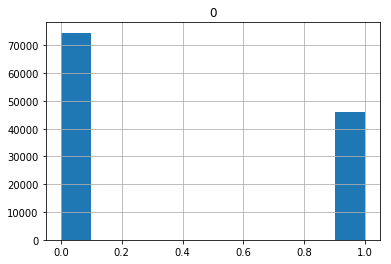

In [118]:
pd.DataFrame(labels2).hist()

In [119]:
df_feature_data2['label2']=labels2

/home/ywang99587/.conda/envs/tptyw/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [120]:
#df_feature_data2.label2.unique

In [121]:
clusters2=[]
clen=0
for i in range(0,2):
    cluster=df_feature_data2[df_feature_data2['label2']==i]
    clusters2.append(cluster)
    clen+=len(cluster)
    print(clusters2[i].shape)
print(clen)

(74542, 34)
(46157, 34)
120699


In [122]:
cluster_stats2 = []
for col in cols:
    ls_col2 = []
    for i in range(0,2):
        statsdf = clusters2[i].describe()
        statscol = statsdf[col]
        ls_col2.append(statscol)
    df_col2 = pd.concat(ls_col2, axis=1).round(2)
    print(df_col2)
    cluster_stats2.append(df_col2)
df_cluster2 = pd.concat(cluster_stats2, axis=1)

       hrs_in_tusc  hrs_in_tusc
count     74542.00     46157.00
mean         90.02       330.24
std          65.65       107.00
min           1.00         3.00
25%          25.00       258.00
50%          88.00       308.00
75%         146.00       364.00
max         357.00       720.00
       hrs_outside_tuscany  hrs_outside_tuscany
count             74542.00             46157.00
mean                  1.09                 0.71
std                   2.63                 1.92
min                   0.00                 0.00
25%                   0.00                 0.00
50%                   0.00                 0.00
75%                   0.00                 0.00
max                  25.00                23.00
       num_loc_in_tusc  num_loc_in_tusc
count         74542.00         46157.00
mean             60.65           154.50
std             142.99           312.28
min               2.00             2.00
25%               8.00            17.00
50%              17.00            44.00


In [46]:
df_cluster2

,hrs_in_tusc,hrs_in_tusc,hrs_outside_tuscany,hrs_outside_tuscany,num_loc_in_tusc,num_loc_in_tusc,num_uniuqe_loc_in_tusc,num_uniuqe_loc_in_tusc,locs_outside_tuscany,locs_outside_tuscany,...,avg_lon,avg_lon,top_lat,top_lat,top_lon,top_lon,std_lat,std_lat,std_lon,std_lon
count,74709.00,45990.00,74709.00,45990.00,74709.00,45990.00,74709.00,45990.00,74709.00,45990.00,...,74709.00,45990.00,74709.00,45990.00,74709.00,45990.00,74709.00,45990.00,74709.00,45990.00
mean,90.24,330.76,1.09,0.72,60.66,154.82,16.07,25.66,6.45,6.61,...,10.85,10.85,43.49,43.24,10.84,10.83,0.23,0.29,0.23,0.29
std,65.74,106.85,2.63,1.92,142.98,312.69,20.83,29.13,28.12,51.30,...,0.54,0.58,0.53,0.67,0.58,0.64,0.30,0.33,0.28,0.35
min,1.00,3.00,0.00,0.00,2.00,2.00,2.00,2.00,-513.00,-4382.00,...,7.19,7.42,38.12,38.90,6.71,7.15,0.00,0.00,0.00,0.00
25%,25.00,259.00,0.00,0.00,8.00,17.00,5.00,9.00,0.00,0.00,...,10.41,10.47,43.24,42.88,10.36,10.40,0.04,0.07,0.05,0.09
50%,88.00,309.00,0.00,0.00,18.00,44.00,9.00,17.00,0.00,0.00,...,10.82,10.81,43.55,43.25,10.82,10.76,0.11,0.17,0.14,0.18
75%,146.00,365.00,0.00,0.00,47.00,133.00,18.00,31.00,2.00,3.00,...,11.25,11.22,43.78,43.57,11.25,11.23,0.29,0.37,0.32,0.37
max,357.00,720.00,25.00,23.00,2836.00,9026.00,257.00,297.00,744.00,1041.00,...,15.20,14.38,46.99,46.99,16.89,16.28,2.74,3.47,4.78,4.88


In [18]:
kmeans.cluster_centers_

array([[ 1.20017839,  1.07590516,  2.46922097,  2.58666862,  0.75033997,
         0.65481102,  0.94895472, -0.23480971,  0.57249011, -0.06821834,
         0.46432374, -0.2160918 ,  0.47387543, -0.22510984,  0.62570536,
         0.42364589],
       [-0.54634363, -0.41785626, -0.46683438, -0.3246774 , -0.22107295,
        -0.62582047, -0.45640667, -0.03285526, -0.4004047 , -0.03580094,
         0.16205205, -0.24388754,  0.17965774, -0.23662632,  0.25477426,
         0.25381288],
       [ 0.19727932,  0.29870153, -0.08411354, -0.17929715, -0.53291728,
         1.21438395, -0.56619423,  1.06335118, -0.78757955,  1.22815271,
         0.13651894,  0.34461848,  0.21151272,  0.21066127,  0.84432535,
         0.82362161],
       [ 1.83329242,  1.35626304, -0.04684062, -0.29588071,  0.98670863,
         0.55264621,  0.31504721,  0.46109216,  0.42361641,  0.11443059,
        -2.71485163,  3.07524804, -2.65168265,  3.0973147 ,  1.72062372,
         1.67564439],
       [ 0.4368905 ,  0.23890029,  0

In [16]:
data_db=df_scaled_loc[df_scaled_loc['std_lat']>0]

In [17]:
#df_feature = StandardScaler().fit_transform(df_feature)
#db = DBSCAN().fit(df_feature, eps=0.95, min_samples=10)
db = DBSCAN(eps=0.5, min_samples=50).fit(data_db)
core_samples = db.core_sample_indices_
labels = db.labels_

In [ ]:
pd.DataFrame(labels).hist()

In [ ]:
## calculate distance between each component pair????



In [ ]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)